# Analysis of Employee Performance
This notebook attempts to examine the employee data to extrapolate a formula that can measure why certain employees perform better

## 1. Import and Connect

In [4]:
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

Connect to Supabase

In [5]:
load_dotenv()

engine = create_engine(os.getenv("SUPABASE_URL") + "?sslmode=require")

with engine.connect() as conn:
    result = conn.execute(text("SELECT version();"))
    print(result.fetchone())

('PostgreSQL 17.6 on aarch64-unknown-linux-gnu, compiled by gcc (GCC) 13.2.0, 64-bit',)


## 2. Load Data

In [6]:
# --- 1. Check tables in your Supabase database ---
tables = pd.read_sql("""
SELECT table_name 
FROM information_schema.tables 
WHERE table_schema='public' 
ORDER BY table_name;
""", engine)
print("✅ Tables found:\n", tables.table_name.to_list())

# --- 2. Define your target tables  ---
table_names = [
    "dim_companies", "dim_areas", "dim_positions", "dim_departments",
    "dim_divisions", "dim_directorates", "dim_grades", "dim_education",
    "dim_majors", "dim_competency_pillars", "employees",
    "profiles_psych", "papi_scores", "strengths",
    "performance_yearly", "competencies_yearly"
]

# --- 3. Create a dictionary to store DataFrames ---
dataframes = {}

# --- 4. Download each table ---
for table in table_names:
    print(f"⬇️  Downloading {table}...")
    df = pd.read_sql(f"SELECT * FROM {table};", engine)
    dataframes[table] = df
    # Save as CSV locally
    df.to_csv(f"{table}.csv", index=False)
    print(f"   → Saved {table}.csv ({len(df)} rows)")

print("✅ All tables downloaded and saved locally.")


✅ Tables found:
 ['competencies_yearly', 'dim_areas', 'dim_companies', 'dim_competency_pillars', 'dim_departments', 'dim_directorates', 'dim_divisions', 'dim_education', 'dim_grades', 'dim_majors', 'dim_positions', 'employees', 'papi_scores', 'performance_yearly', 'profiles_psych', 'strengths']
⬇️  Downloading dim_companies...
   → Saved dim_companies.csv (4 rows)
⬇️  Downloading dim_areas...
   → Saved dim_areas.csv (4 rows)
⬇️  Downloading dim_positions...
   → Saved dim_positions.csv (6 rows)
⬇️  Downloading dim_departments...
   → Saved dim_departments.csv (6 rows)
⬇️  Downloading dim_divisions...
   → Saved dim_divisions.csv (5 rows)
⬇️  Downloading dim_directorates...
   → Saved dim_directorates.csv (3 rows)
⬇️  Downloading dim_grades...
   → Saved dim_grades.csv (3 rows)
⬇️  Downloading dim_education...
   → Saved dim_education.csv (4 rows)
⬇️  Downloading dim_majors...
   → Saved dim_majors.csv (6 rows)
⬇️  Downloading dim_competency_pillars...
   → Saved dim_competency_pillars

Check loaded data

In [7]:
dataframes["employees"].head()


,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,3,1,64
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,1,2,16
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,3,1,58
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,2,5,15
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,1,5,34


Assign to variable for naming

In [8]:
# Pull tables directly from the dictionary
employees           = dataframes["employees"]
dim_companies       = dataframes["dim_companies"]
dim_areas           = dataframes["dim_areas"]
dim_positions       = dataframes["dim_positions"]
dim_departments     = dataframes["dim_departments"]
dim_divisions       = dataframes["dim_divisions"]
dim_directorates    = dataframes["dim_directorates"]
dim_grades          = dataframes["dim_grades"]
dim_education       = dataframes["dim_education"]
dim_majors          = dataframes["dim_majors"]
performance_yearly  = dataframes["performance_yearly"]
competencies_yearly = dataframes["competencies_yearly"]
papi_scores         = dataframes["papi_scores"]
profiles_psych      = dataframes["profiles_psych"]
strengths           = dataframes["strengths"]
dim_competency_pillars = dataframes["dim_competency_pillars"]

## 3. Data Exploration

Check data length

In [9]:
for name, df in [
    ("employees", employees),
    ("dim_companies", dim_companies),
    ("dim_areas", dim_areas),
    ("dim_positions", dim_positions),
    ("dim_departments", dim_departments),
    ("dim_divisions", dim_divisions),
    ("dim_directorates", dim_directorates),
    ("dim_grades", dim_grades),
    ("dim_education", dim_education),
    ("dim_majors", dim_majors)
]:
    print(f"{name:20s} → {len(df):5d} rows")


employees            →  2010 rows
dim_companies        →     4 rows
dim_areas            →     4 rows
dim_positions        →     6 rows
dim_departments      →     6 rows
dim_divisions        →     5 rows
dim_directorates     →     3 rows
dim_grades           →     3 rows
dim_education        →     4 rows
dim_majors           →     6 rows


Rename to merge

In [10]:
# Rename all dim_ tables' "name" columns to unique names
dim_companies.rename(columns={"name": "company_name"}, inplace=True)
dim_areas.rename(columns={"name": "area_name"}, inplace=True)
dim_positions.rename(columns={"name": "position_name"}, inplace=True)
dim_departments.rename(columns={"name": "department_name"}, inplace=True)
dim_divisions.rename(columns={"name": "division_name"}, inplace=True)
dim_directorates.rename(columns={"name": "directorate_name"}, inplace=True)
dim_grades.rename(columns={"name": "grade_name"}, inplace=True)
dim_education.rename(columns={"name": "education_name"}, inplace=True)
dim_majors.rename(columns={"name": "major_name"}, inplace=True)


Merge into single employee table

In [11]:
employees_base = (
    employees
    .merge(dim_companies, on="company_id", how="left")
    .merge(dim_areas, on="area_id", how="left")
    .merge(dim_positions, on="position_id", how="left")
    .merge(dim_departments, on="department_id", how="left")
    .merge(dim_divisions, on="division_id", how="left")
    .merge(dim_directorates, on="directorate_id", how="left")
    .merge(dim_grades, on="grade_id", how="left")
    .merge(dim_education, on="education_id", how="left")
    .merge(dim_majors, on="major_id", how="left")
)

Check merge results

In [12]:
employees_base.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,years_of_service_months,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,58,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,15,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,34,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology


Only select merged columns

In [13]:
base_clean = employees_base[[
    "employee_id", "fullname", "company_name", "area_name", "position_name",
    "department_name", "division_name", "directorate_name",
    "grade_name", "education_name", "major_name",
    "years_of_service_months"
]]


Check cleaned merged table

In [14]:
base_clean.head()

,employee_id,fullname,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name,years_of_service_months
0,EMP100000,Rendra Pratama,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,64
1,EMP100001,Wulan Setiawan,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,16
2,EMP100002,Julia Jatmiko Situmorang,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business,58
3,EMP100003,Oka Halim,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology,15
4,EMP100004,Dwi Pratama,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology,34


In [15]:
base_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   employee_id              2010 non-null   object
 1   fullname                 2010 non-null   object
 2   company_name             2010 non-null   object
 3   area_name                2010 non-null   object
 4   position_name            2010 non-null   object
 5   department_name          2010 non-null   object
 6   division_name            2010 non-null   object
 7   directorate_name         2010 non-null   object
 8   grade_name               2010 non-null   object
 9   education_name           2010 non-null   object
 10  major_name               2010 non-null   object
 11  years_of_service_months  2010 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 188.6+ KB


Check for performance data

In [16]:
performance_yearly.year.value_counts()

year
2021.0    2010
2022.0    2010
2023.0    2010
2024.0    2010
2025.0    2010
Name: count, dtype: int64

Check values of performances

In [17]:
performance_yearly.rating.value_counts()

rating
3.0     3339
4.0     2437
2.0     1578
5.0      881
1.0      672
0.0       15
6.0       13
99.0       7
Name: count, dtype: int64

In [18]:
performance_yearly["rating"].dtype
performance_yearly["rating"].unique()[:20]


array([ 2., nan,  3.,  4.,  5.,  1.,  0., 99.,  6.])

Check amount of null

In [19]:
performance_yearly["rating"].isna().sum()

1108

Assuming data outside ratings 1-5 are misinputs

In [20]:
performance_yearly_clean = performance_yearly.copy()

# Replace invalid ratings with NaN
performance_yearly_clean.loc[~performance_yearly_clean["rating"].between(1, 5), "rating"] = None

# Optional: check result
performance_yearly_clean["rating"].value_counts(dropna=False)


rating
3.0    3339
4.0    2437
2.0    1578
NaN    1143
5.0     881
1.0     672
Name: count, dtype: int64

Flag rating 5 employees

In [21]:
# Create a helper column to mark rating 5
performance_yearly_clean["is_top"] = (performance_yearly_clean["rating"] == 5).astype(int)

# Summarize performance per employee
top_perf_flag = (
    performance_yearly_clean
    .groupby("employee_id", as_index=False)
    .agg(
        total_years_rated=("year", "count"),
        num_top_years=("is_top", "sum"),
        top_years=("year", lambda y: sorted(y[performance_yearly_clean.loc[y.index, "rating"] == 5].unique()))
    )
)

# Flag employees who ever had rating 5
top_perf_flag["has_rating_5"] = top_perf_flag["num_top_years"] > 0


In [22]:
base_with_perf = base_clean.merge(top_perf_flag, on="employee_id", how="left")
base_with_perf["has_rating_5"].fillna(False, inplace=True)

base_with_perf.head()

,employee_id,fullname,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name,years_of_service_months,total_years_rated,num_top_years,top_years,has_rating_5
0,EMP100000,Rendra Pratama,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,64,5,0,[],False
1,EMP100001,Wulan Setiawan,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,16,5,0,[],False
2,EMP100002,Julia Jatmiko Situmorang,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business,58,5,0,[],False
3,EMP100003,Oka Halim,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology,15,5,0,[],False
4,EMP100004,Dwi Pratama,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology,34,5,0,[],False


Count how many employees have ever gotten rating 5

In [23]:
# Total employees
total_employees = base_with_perf["employee_id"].nunique()

# Employees who ever achieved rating 5
top_employees = base_with_perf.loc[base_with_perf["has_rating_5"] == True, "employee_id"].nunique()

print(f"Total employees: {total_employees}")
print(f"Employees who ever reached rating 5: {top_employees}")
print(f"Percentage: {top_employees / total_employees * 100:.2f}%")


Total employees: 2010
Employees who ever reached rating 5: 735
Percentage: 36.57%


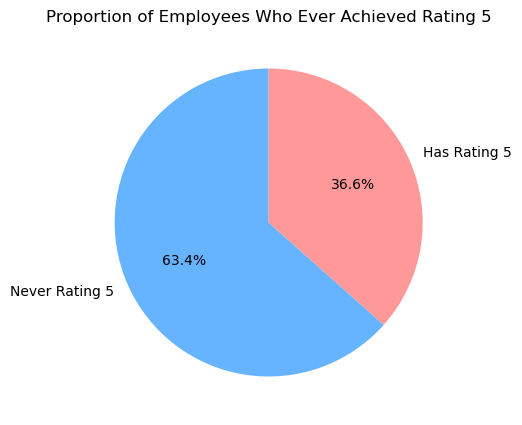

In [24]:
counts = base_with_perf["has_rating_5"].value_counts().rename({True: "Has Rating 5", False: "Never Rating 5"})
plt.figure(figsize=(5,5))
plt.pie(counts.values, labels=counts.index, autopct="%.1f%%", startangle=90, colors=["#66b3ff", "#ff9999"])
plt.title("Proportion of Employees Who Ever Achieved Rating 5")
plt.show()



Split into top group and non-top group

In [25]:
top_group = base_with_perf.query("has_rating_5 == True")
non_top_group = base_with_perf.query("has_rating_5 == False")

print(f"Top performers: {len(top_group)}")
print(f"Non-top performers: {len(non_top_group)}")


Top performers: 735
Non-top performers: 1275


### 3.1. Competency Scores

Check competency scores for Top performing and Non top performing employees

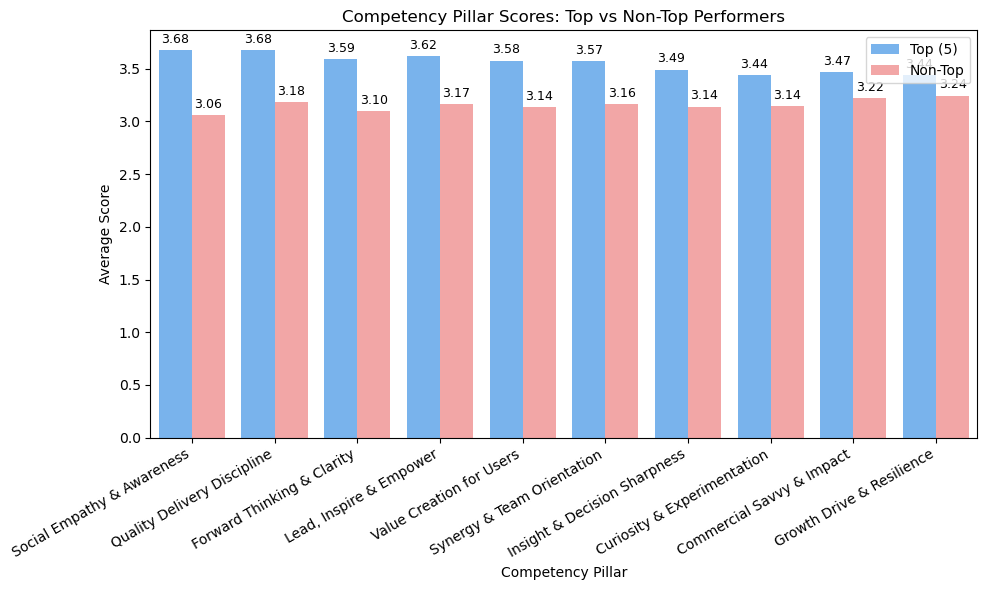

has_rating_5,Non-Top,Top (5),Δ (Top - Non-Top)
pillar_label,,,
Social Empathy & Awareness,3.06,3.68,0.61
Quality Delivery Discipline,3.18,3.68,0.50
Forward Thinking & Clarity,3.10,3.59,0.49
"Lead, Inspire & Empower",3.17,3.62,0.46
Value Creation for Users,3.14,3.58,0.44
Synergy & Team Orientation,3.16,3.57,0.41
Insight & Decision Sharpness,3.14,3.49,0.35
Curiosity & Experimentation,3.14,3.44,0.29
Commercial Savvy & Impact,3.22,3.47,0.25


In [26]:
# Fix datatypes safely
competencies_yearly["score"] = pd.to_numeric(competencies_yearly["score"], errors="coerce")
competencies_yearly["year"] = pd.to_numeric(competencies_yearly["year"], errors="coerce")

# Merge with labels
competency_merged = (
    competencies_yearly
    .merge(dim_competency_pillars, on="pillar_code", how="left")
    .merge(base_with_perf[["employee_id", "has_rating_5"]], on="employee_id", how="left")
)

# Compute mean score per pillar per group
competency_summary = (
    competency_merged.groupby(["pillar_label", "has_rating_5"])["score"]
    .mean()
    .reset_index()
    .pivot(index="pillar_label", columns="has_rating_5", values="score")
    .rename(columns={True: "Top (5)", False: "Non-Top"})
)

# Calculate difference (Top - NonTop)
competency_summary["Δ (Top - Non-Top)"] = competency_summary["Top (5)"] - competency_summary["Non-Top"]
competency_summary = competency_summary.sort_values("Δ (Top - Non-Top)", ascending=False)

# Melt for seaborn (vertical bar chart)
plot_df = competency_summary.reset_index().melt(
    id_vars="pillar_label", 
    value_vars=["Top (5)", "Non-Top"],
    var_name="Group", 
    value_name="Average Score"
)

# Plot vertical bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_df,
    x="pillar_label",
    y="Average Score",
    hue="Group",
    palette=["#66b3ff", "#ff9999"]
)

# Add values above bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=3)

plt.title("Competency Pillar Scores: Top vs Non-Top Performers")
plt.xlabel("Competency Pillar")
plt.ylabel("Average Score")
plt.xticks(rotation=30, ha="right")
plt.legend(title="")
plt.tight_layout()
plt.show()

# Display clean table
display(
    competency_summary.round(2)[["Non-Top", "Top (5)", "Δ (Top - Non-Top)"]]
)

Insight:
- Obviously top performing employees on average have higher competency scores than non-top-performing employees
- We can see that several scoring categories are much higher in average score for top performing employees, such as: Social Empathy & Awareness, Quality Delivery Discipline, Forward Thinking & Clarity, Lead, Inspire & Empower, Value Creation for Users, Synergy & Team Orientation, and Insight & Decision Sharpness.
- This implies that the categories mentioned are drivers for employees to be considered a top performer.

### 3.2. PAPI Kostick scores

Work-style preferences (initiative, leadership, conformity, etc.).

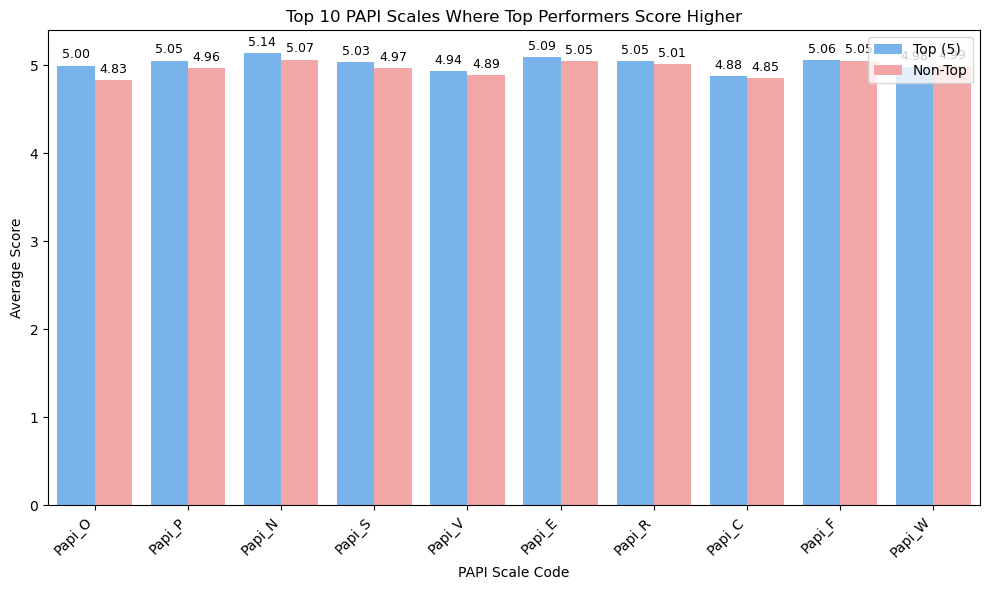

has_rating_5,scale_code,Non-Top,Top (5),Δ (Top - Non-Top)
0,Papi_O,4.83,5.00,0.16
1,Papi_P,4.96,5.05,0.09
2,Papi_N,5.07,5.14,0.07
3,Papi_S,4.97,5.03,0.06
4,Papi_V,4.89,4.94,0.05
5,Papi_E,5.05,5.09,0.04
6,Papi_R,5.01,5.05,0.04
7,Papi_C,4.85,4.88,0.02
8,Papi_F,5.05,5.06,0.01
9,Papi_W,4.99,4.98,-0.01


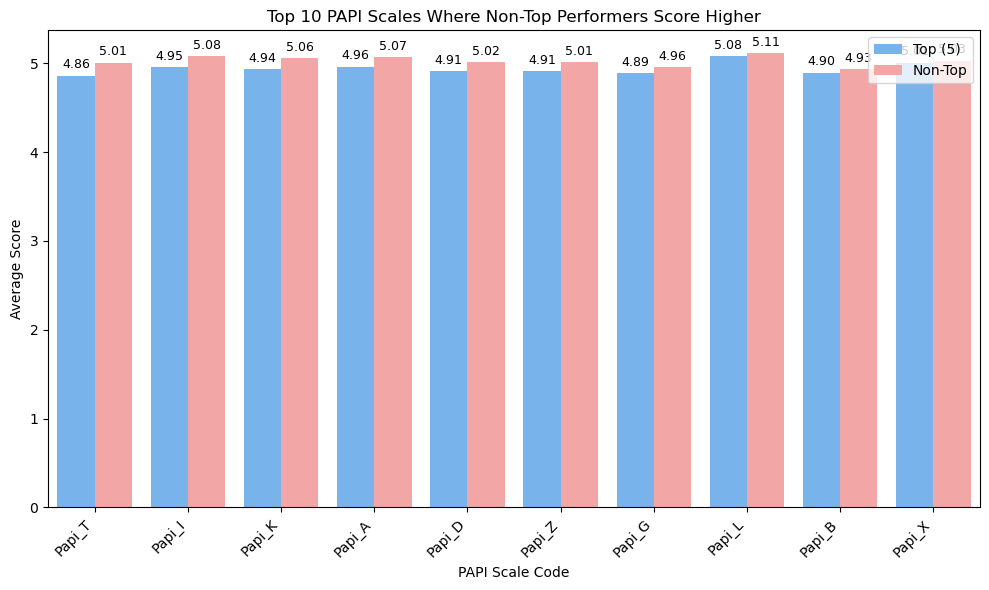

has_rating_5,scale_code,Non-Top,Top (5),Δ (Top - Non-Top)
0,Papi_T,5.01,4.86,-0.14
1,Papi_I,5.08,4.95,-0.13
2,Papi_K,5.06,4.94,-0.12
3,Papi_A,5.07,4.96,-0.11
4,Papi_D,5.02,4.91,-0.10
5,Papi_Z,5.01,4.91,-0.10
6,Papi_G,4.96,4.89,-0.07
7,Papi_L,5.11,5.08,-0.04
8,Papi_B,4.93,4.90,-0.04
9,Papi_X,5.03,5.01,-0.02


In [27]:
# --- Ensure numeric ---
papi_scores["score"] = pd.to_numeric(papi_scores["score"], errors="coerce")

# --- Merge with performance group ---
papi_merged = papi_scores.merge(
    base_with_perf[["employee_id", "has_rating_5"]],
    on="employee_id",
    how="left"
)

# --- Compute mean PAPI score per group ---
papi_summary = (
    papi_merged.groupby(["scale_code", "has_rating_5"])["score"]
    .mean()
    .reset_index()
    .pivot(index="scale_code", columns="has_rating_5", values="score")
    .rename(columns={True: "Top (5)", False: "Non-Top"})
)

# --- Calculate Δ (Top - NonTop) ---
papi_summary["Δ (Top - Non-Top)"] = papi_summary["Top (5)"] - papi_summary["Non-Top"]

# =====================================================
# 🎯 Top 10 Highest Δ — where Top performers score higher
# =====================================================
papi_top10 = papi_summary.sort_values("Δ (Top - Non-Top)", ascending=False).head(10).reset_index()

plot_df_top = papi_top10.melt(
    id_vars="scale_code", 
    value_vars=["Top (5)", "Non-Top"],
    var_name="Group", 
    value_name="Average Score"
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_df_top,
    x="scale_code",
    y="Average Score",
    hue="Group",
    palette=["#66b3ff", "#ff9999"]
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=3)

plt.title("Top 10 PAPI Scales Where Top Performers Score Higher")
plt.xlabel("PAPI Scale Code")
plt.ylabel("Average Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="")
plt.tight_layout()
plt.show()

display(
    papi_top10[["scale_code", "Non-Top", "Top (5)", "Δ (Top - Non-Top)"]].round(2)
)

# =====================================================
# 🔻 Top 10 Lowest Δ — where Non-Top performers score higher
# =====================================================
papi_bottom10 = papi_summary.sort_values("Δ (Top - Non-Top)", ascending=True).head(10).reset_index()

plot_df_bottom = papi_bottom10.melt(
    id_vars="scale_code", 
    value_vars=["Top (5)", "Non-Top"],
    var_name="Group", 
    value_name="Average Score"
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_df_bottom,
    x="scale_code",
    y="Average Score",
    hue="Group",
    palette=["#66b3ff", "#ff9999"]
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=3)

plt.title("Top 10 PAPI Scales Where Non-Top Performers Score Higher")
plt.xlabel("PAPI Scale Code")
plt.ylabel("Average Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="")
plt.tight_layout()
plt.show()

display(
    papi_bottom10[["scale_code", "Non-Top", "Top (5)", "Δ (Top - Non-Top)"]].round(2)
)


Insights:
- We can see that in terms of average PAPI scores, the difference between top performers and non top performers is not as pronounced.
- Nevertheless, PAPI scores O, P, N, S are higher on top performers while scores T, I, K, A, D, Z, and G are lower when compared to non-top performers
- O = Need for Closeness and Affection, P = Need to Control Others, N = Need to Finish Task, S = Social Extension
- T = Pace, I = Ease in Decision Making, K = Need to be Forceful, A = Need to Achieve, D = Interest in Working With Details, Z = Need for Change, G = Hard Intense Worker
- Strangely, the qualities we often generally associate with top workers are instead lower on average than non top performers.

### 3.3. Aptitude

1. Pauli (Kraepelin-type Mental Arithmetic): Continuous addition task, speed + accuracy + mental stamina. (scale 20-100)
2. GTQ (Aptitude Subtests): Short cognitive/aptitude components (e.g., reasoning, numeracy). (scale 1-50)
3. TIKI (Short Cognitive/Attention Tasks): Brief attention/processing subtests. (scale 1-10)
4. Faxtor (Internal Cognitive/Attention Index): Internal composite (attention/processing) used in the dummy. (scale 20-100)
5. IQ / Cognitive Index: General cognitive/problem-solving potential (proxy). (approx. 80–140)

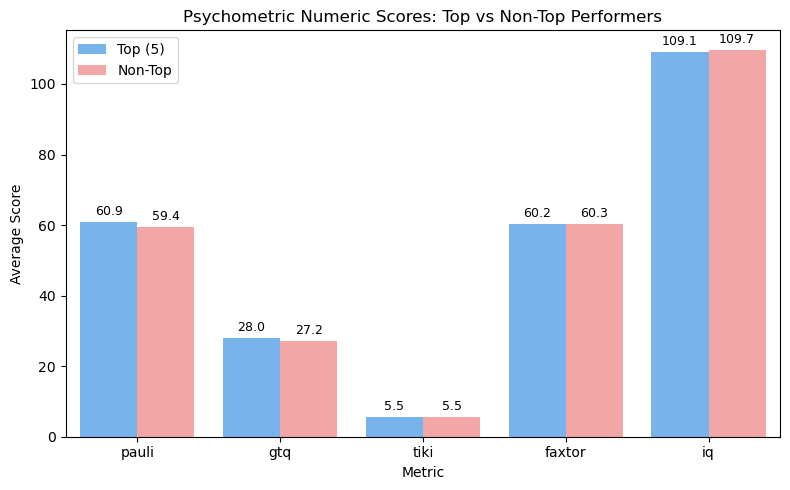

has_rating_5,Non-Top,Top (5),Δ (Top - Non-Top)
pauli,59.42,60.93,1.51
gtq,27.19,27.95,0.77
tiki,5.45,5.53,0.08
faxtor,60.32,60.23,-0.09
iq,109.73,109.13,-0.59


In [28]:
# --- Merge with performance labels ---
psych_merged = profiles_psych.merge(
    base_with_perf[["employee_id", "has_rating_5"]],
    on="employee_id",
    how="left"
)

# ==================================================
# 🧩 PART A — Numeric variables (Pauli, Faxtor, IQ, GTQ, Tiki)
# ==================================================
numeric_cols = ["pauli", "faxtor", "iq", "gtq", "tiki"]
for col in numeric_cols:
    psych_merged[col] = pd.to_numeric(psych_merged[col], errors="coerce")

numeric_summary = (
    psych_merged.groupby("has_rating_5")[numeric_cols]
    .mean(numeric_only=True)
    .T
    .rename(columns={True: "Top (5)", False: "Non-Top"})
)
numeric_summary["Δ (Top - Non-Top)"] = numeric_summary["Top (5)"] - numeric_summary["Non-Top"]
numeric_summary = numeric_summary.sort_values("Δ (Top - Non-Top)", ascending=False)

# --- Plot numeric comparison ---
plot_df = numeric_summary.reset_index().melt(
    id_vars="index", 
    value_vars=["Top (5)", "Non-Top"],
    var_name="Group", 
    value_name="Average Score"
).rename(columns={"index": "Metric"})

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=plot_df,
    x="Metric",
    y="Average Score",
    hue="Group",
    palette=["#66b3ff", "#ff9999"]
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", fontsize=9, padding=3)

plt.title("Psychometric Numeric Scores: Top vs Non-Top Performers")
plt.xlabel("Metric")
plt.ylabel("Average Score")
plt.legend(title="")
plt.tight_layout()
plt.show()

display(numeric_summary.round(2))


Insights:
- Not much difference again but we can see Pauli and GTQ scores are higher in top performers.
- Surprisingly IQ is on average slightly lower for top performers.

### 3.5. Behavioral Style & Type Preference

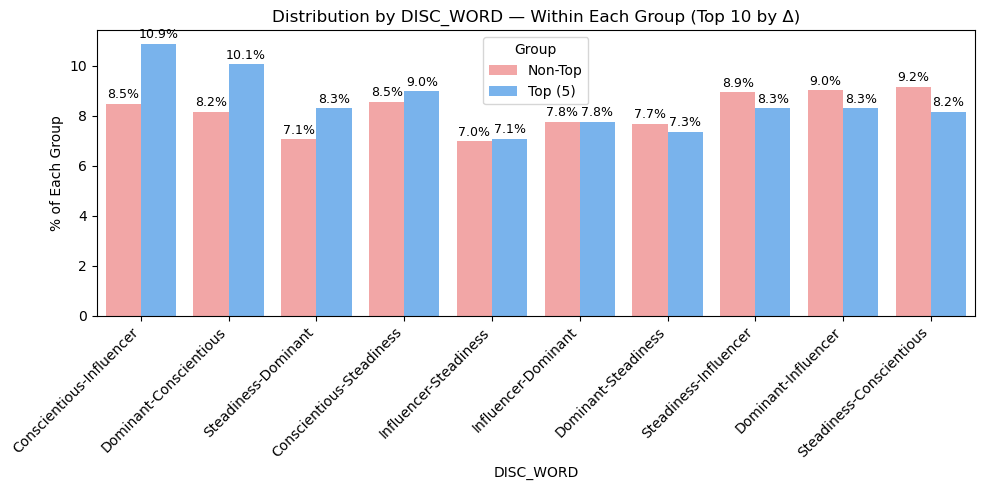


📊 Group-normalized percentages (Top 10 by Δ) — DISC_WORD


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
disc_word,,,
Conscientious-Influencer,8.47,10.88,2.41
Dominant-Conscientious,8.16,10.07,1.91
Steadiness-Dominant,7.06,8.30,1.24
Conscientious-Steadiness,8.55,8.98,0.43
Influencer-Steadiness,6.98,7.07,0.09
Influencer-Dominant,7.76,7.76,-0.01
Dominant-Steadiness,7.69,7.35,-0.34
Steadiness-Influencer,8.94,8.30,-0.64
Dominant-Influencer,9.02,8.30,-0.72


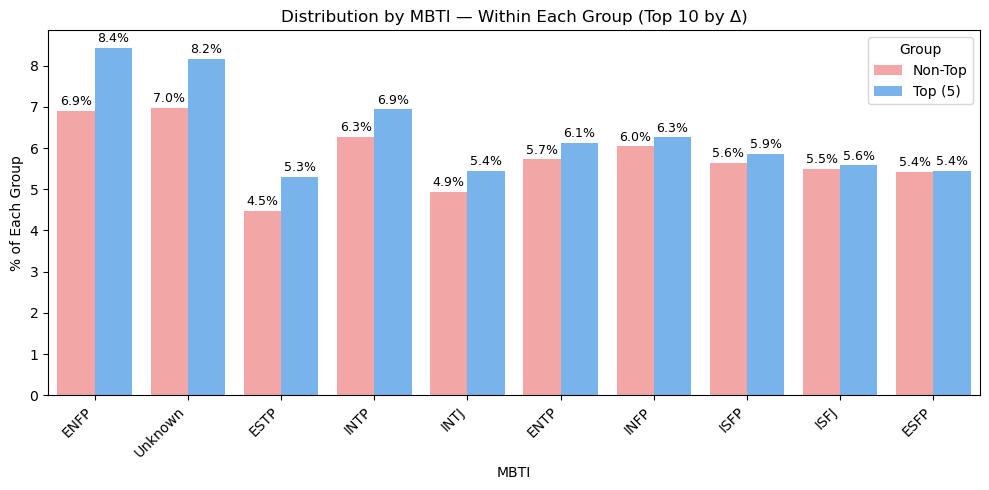


📊 Group-normalized percentages (Top 10 by Δ) — MBTI


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
mbti,,,
ENFP,6.90,8.44,1.53
Unknown,6.98,8.16,1.18
ESTP,4.47,5.31,0.84
INTP,6.27,6.94,0.66
INTJ,4.94,5.44,0.50
ENTP,5.73,6.12,0.40
INFP,6.04,6.26,0.22
ISFP,5.65,5.85,0.20
ISFJ,5.49,5.58,0.09


In [29]:
# --- 1️⃣ Normalize MBTI casing before analysis ---
if "mbti" in profiles_psych.columns:
    profiles_psych["mbti"] = profiles_psych["mbti"].str.upper().str.strip()

# --- 2️⃣ Ensure group label exists ---
base_with_perf["has_rating_5_label"] = base_with_perf["has_rating_5"].map({
    True: "Top (5)",
    False: "Non-Top"
})

# --- 3️⃣ Merge profiles with performance label ---
psych_merged = profiles_psych.merge(
    base_with_perf[["employee_id", "has_rating_5_label"]],
    on="employee_id",
    how="left"
)

# --- 4️⃣ Columns to analyze ---
cat_cols = ["disc_word", "mbti"]
TOP_N = 10  # adjust how many categories to show

# --- 5️⃣ Loop through each categorical psych column ---
for col in cat_cols:
    if col not in psych_merged.columns:
        print(f"⚠️ Skipping '{col}' (not present)")
        continue

    # --- Count and percentage within each group ---
    group_counts = (
        psych_merged
        .fillna({col: "Unknown"})
        .groupby(["has_rating_5_label", col])
        .size()
        .reset_index(name="count")
    )
    group_counts["percent_within_group"] = (
        group_counts.groupby("has_rating_5_label")["count"]
        .transform(lambda x: 100 * x / x.sum())
    )

    # --- Pivot for summary table ---
    pivot = group_counts.pivot(
        index=col,
        columns="has_rating_5_label",
        values="percent_within_group"
    ).fillna(0)

    # Ensure both groups exist
    for g in ["Non-Top", "Top (5)"]:
        if g not in pivot.columns:
            pivot[g] = 0.0

    pivot = pivot[["Non-Top", "Top (5)"]]
    pivot["Δ (Top - Non-Top)"] = pivot["Top (5)"] - pivot["Non-Top"]

    # --- Sort categories by delta (descending) and limit to Top N ---
    pivot_sorted = pivot.sort_values("Δ (Top - Non-Top)", ascending=False)
    top_categories = pivot_sorted.head(TOP_N).index.tolist()

    # --- Prepare plotting data ---
    plot_df = group_counts[group_counts[col].isin(top_categories)].copy()

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        data=plot_df,
        x=col,
        y="percent_within_group",
        hue="has_rating_5_label",
        hue_order=["Non-Top", "Top (5)"],
        order=top_categories,
        palette=["#ff9999", "#66b3ff"]
    )

    # Annotate bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9, padding=2)

    plt.title(f"Distribution by {col.upper()} — Within Each Group (Top {TOP_N} by Δ)")
    plt.ylabel("% of Each Group")
    plt.xlabel(col.upper())
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()

    # --- Display sorted summary table ---
    print(f"\n📊 Group-normalized percentages (Top {TOP_N} by Δ) — {col.upper()}")
    display(pivot_sorted.round(2).head(TOP_N))
    print("\n" + "="*80 + "\n")


Insights:
- Behavioral styles of top performers are higher on average in Conscientious-Influencer, Dominant-Conscientious, Steadiness-Dominant.
- While non top performer beats top performers in Steadiness-Influencer, Dominant-Influencer, Steadiness-Conscientious.
- For type preferences, ENFP, ESTP, and INTP are the personality types that are more present in top performers than non top performers.

### 3.6. Clifton Strengths (Top Themes)

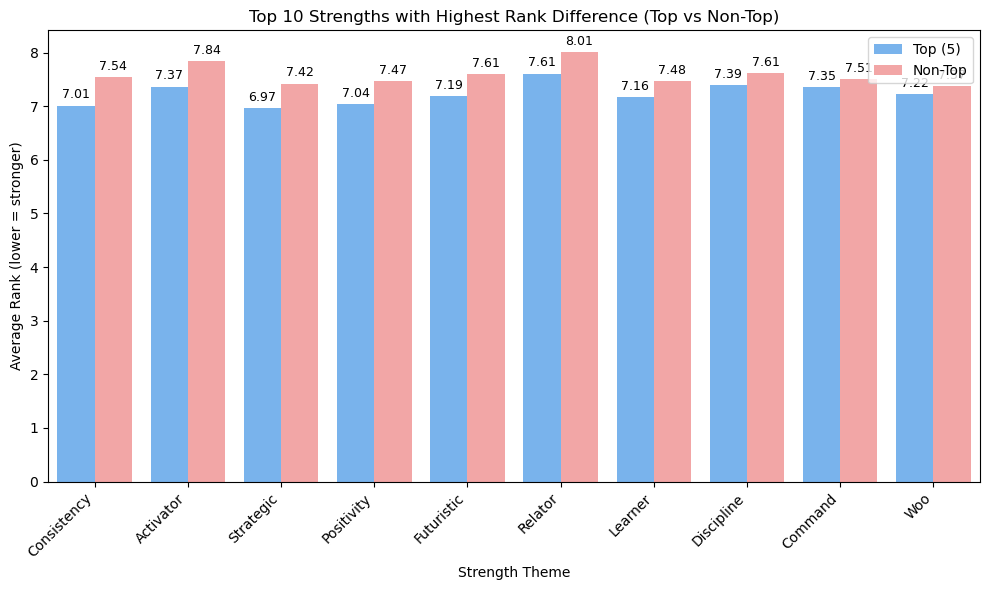

has_rating_5,theme,Non-Top,Top (5),Δ (NonTop - Top)
0,Consistency,7.54,7.01,0.53
1,Activator,7.84,7.37,0.47
2,Strategic,7.42,6.97,0.45
3,Positivity,7.47,7.04,0.43
4,Futuristic,7.61,7.19,0.42
5,Relator,8.01,7.61,0.41
6,Learner,7.48,7.16,0.31
7,Discipline,7.61,7.39,0.22
8,Command,7.51,7.35,0.16
9,Woo,7.37,7.22,0.15


In [30]:
# --- Merge with performance group ---
strengths_merged = strengths.merge(
    base_with_perf[["employee_id", "has_rating_5"]],
    on="employee_id",
    how="left"
)

# --- Compute mean rank per theme per group ---
strengths_summary = (
    strengths_merged
    .groupby(["theme", "has_rating_5"])["rank"]
    .mean()
    .reset_index()
    .pivot(index="theme", columns="has_rating_5", values="rank")
    .rename(columns={True: "Top (5)", False: "Non-Top"})
)

# --- Calculate Δ (NonTop - Top): positive means Top ranks it higher (better/lower rank) ---
strengths_summary["Δ (NonTop - Top)"] = strengths_summary["Non-Top"] - strengths_summary["Top (5)"]

# --- Sort and take Top 10 ---
strengths_top10 = strengths_summary.sort_values("Δ (NonTop - Top)", ascending=False).head(10).reset_index()

# --- Prepare for plotting ---
plot_df = strengths_top10.melt(
    id_vars="theme",
    value_vars=["Top (5)", "Non-Top"],
    var_name="Group",
    value_name="Average Rank"
)

# --- Plot ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_df,
    x="theme",
    y="Average Rank",
    hue="Group",
    palette=["#66b3ff", "#ff9999"]
)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=3)

plt.title("Top 10 Strengths with Highest Rank Difference (Top vs Non-Top)")
plt.xlabel("Strength Theme")
plt.ylabel("Average Rank (lower = stronger)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="")
plt.tight_layout()
plt.show()

# --- Display tabular summary ---
display(
    strengths_top10[["theme", "Non-Top", "Top (5)", "Δ (NonTop - Top)"]].round(2)
)

Insights:
- Top performers obviously will rank higher than non top performers
- However we can see that consistency, activator, strategic, positivity, futuristic, and relator are on average slightly more pronounced in top performers

In [31]:
base_with_perf

,employee_id,fullname,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name,years_of_service_months,total_years_rated,num_top_years,top_years,has_rating_5,has_rating_5_label
0,EMP100000,Rendra Pratama,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,64,5,0,[],False,Non-Top
1,EMP100001,Wulan Setiawan,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,16,5,0,[],False,Non-Top
2,EMP100002,Julia Jatmiko Situmorang,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business,58,5,0,[],False,Non-Top
3,EMP100003,Oka Halim,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology,15,5,0,[],False,Non-Top
4,EMP100004,Dwi Pratama,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology,34,5,0,[],False,Non-Top
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,DUP1942,Dewi Fadillah Hidayat,PT Mandala Distribution Center,Store,Brand Executive,Marketing,Digital Marketing,Commercial,IV,S1,Design,79,5,1,[2025.0],True,Top (5)
2006,DUP2096,Putri Wibowo,PT Lumo Cosmetics Asia,Plant,HRBP,Marketing,Operations,HR & Corp Affairs,III,S2,Engineering,49,5,1,[2023.0],True,Top (5)
2007,DUP4177,Adi Ginting,PT Mandala Distribution Center,HQ,Supply Planner,Marketing,Sales,HR & Corp Affairs,V,S1,Business,75,5,0,[],False,Non-Top
2008,DUP9801,Ayu Kusuma Santoso,PT VASKA Wellness,Plant,Finance Officer,IT,Digital Marketing,Technology,III,S1,Engineering,7,5,2,"[2022.0, 2025.0]",True,Top (5)


### 3.7 Employee information

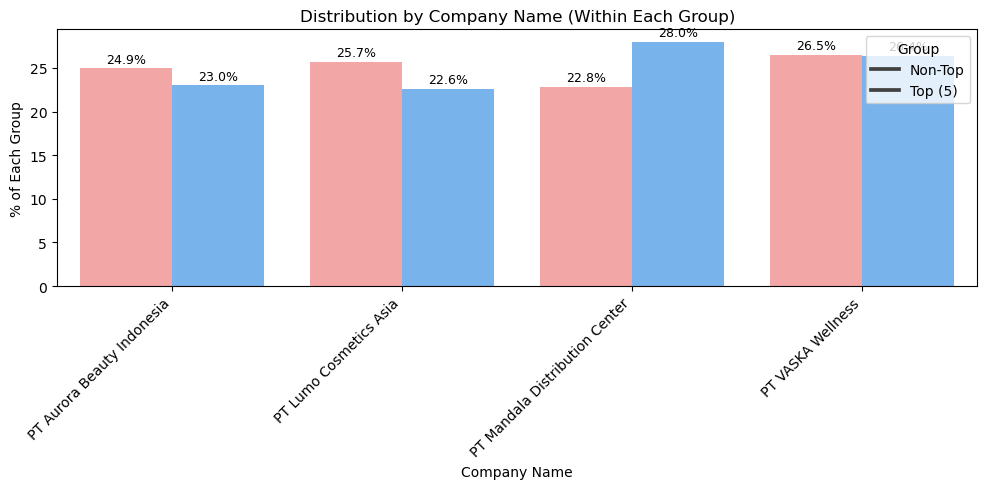


📊 Top vs Non-Top — Company Name


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
company_name,,,
PT Mandala Distribution Center,22.8,28.0,5.2
PT VASKA Wellness,26.5,26.4,-0.1
PT Aurora Beauty Indonesia,24.9,23.0,-1.9
PT Lumo Cosmetics Asia,25.7,22.6,-3.1


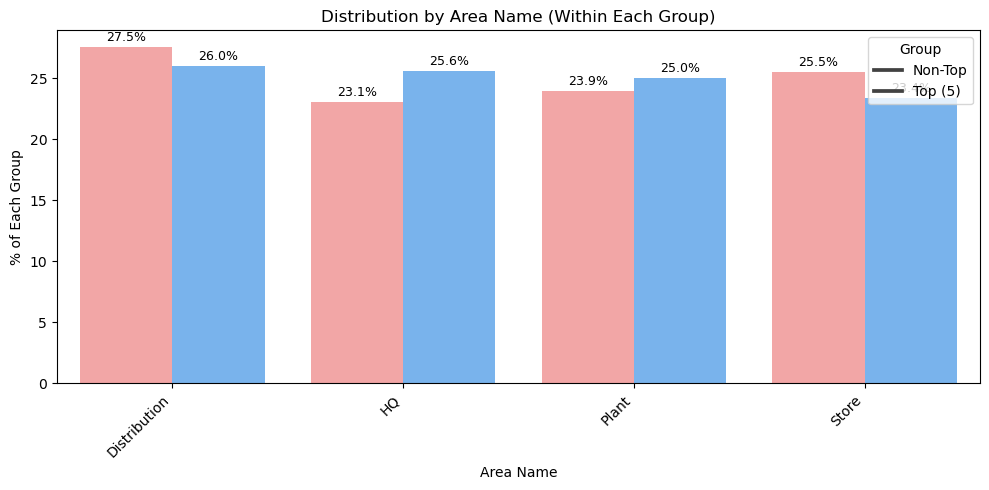


📊 Top vs Non-Top — Area Name


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
area_name,,,
Distribution,27.5,26.0,-1.5
HQ,23.1,25.6,2.5
Plant,23.9,25.0,1.1
Store,25.5,23.4,-2.1


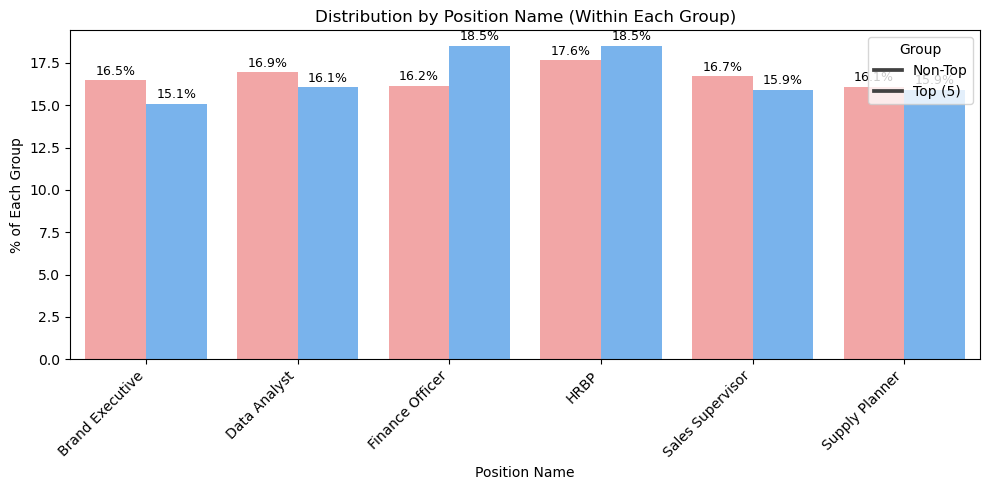


📊 Top vs Non-Top — Position Name


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
position_name,,,
Finance Officer,16.2,18.5,2.3
HRBP,17.6,18.5,0.9
Data Analyst,16.9,16.1,-0.9
Sales Supervisor,16.7,15.9,-0.8
Supply Planner,16.1,15.9,-0.2
Brand Executive,16.5,15.1,-1.4


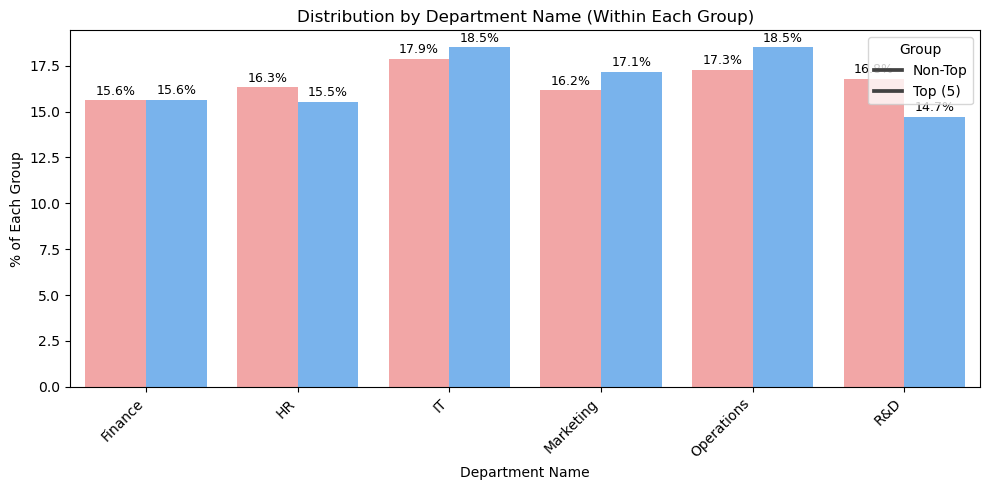


📊 Top vs Non-Top — Department Name


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
department_name,,,
IT,17.9,18.5,0.6
Operations,17.3,18.5,1.2
Marketing,16.2,17.1,1.0
Finance,15.6,15.6,0.0
HR,16.3,15.5,-0.8
R&D,16.8,14.7,-2.1


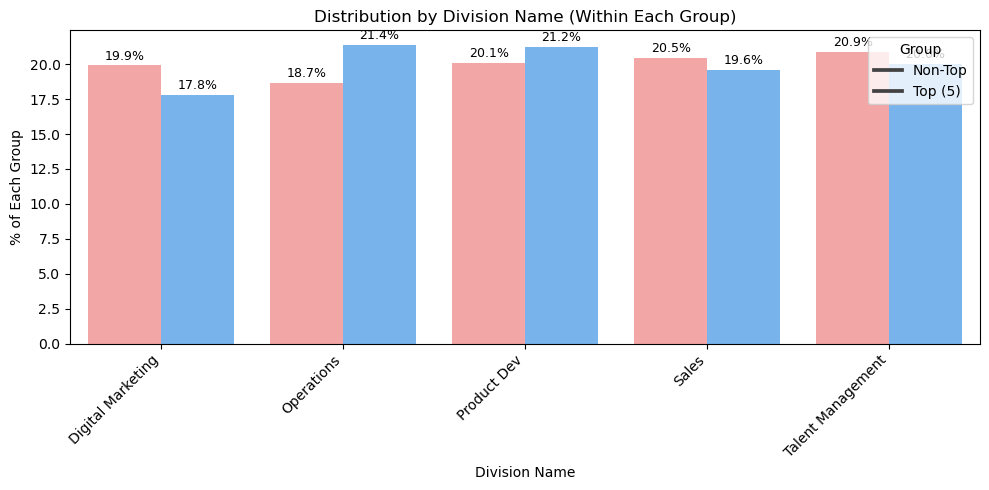


📊 Top vs Non-Top — Division Name


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
division_name,,,
Operations,18.7,21.4,2.7
Product Dev,20.1,21.2,1.1
Talent Management,20.9,20.0,-0.9
Sales,20.5,19.6,-0.9
Digital Marketing,19.9,17.8,-2.1


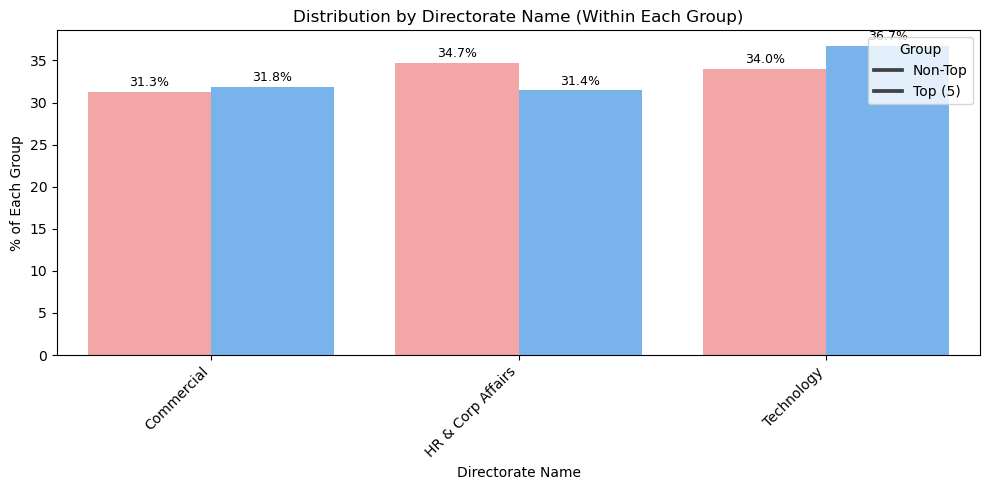


📊 Top vs Non-Top — Directorate Name


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
directorate_name,,,
Technology,34.0,36.7,2.8
Commercial,31.3,31.8,0.5
HR & Corp Affairs,34.7,31.4,-3.3


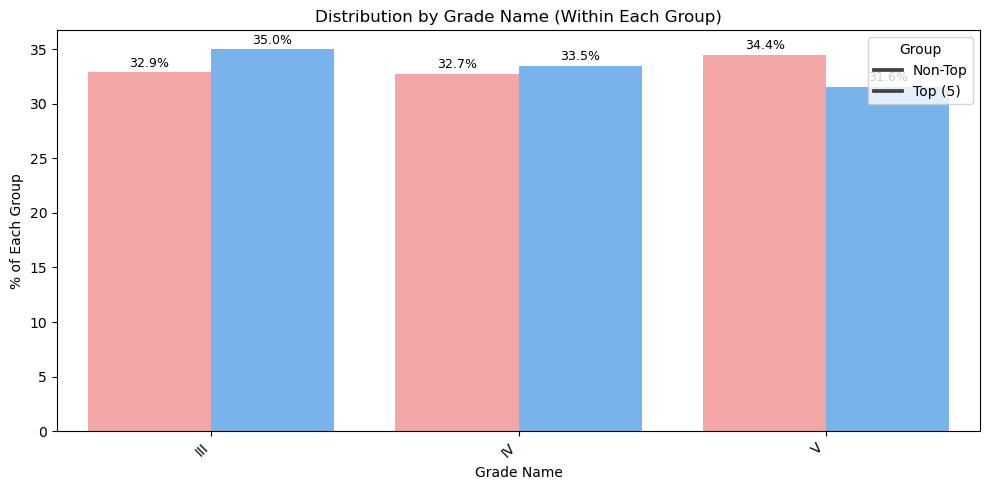


📊 Top vs Non-Top — Grade Name


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
grade_name,,,
III,32.9,35.0,2.1
IV,32.7,33.5,0.8
V,34.4,31.6,-2.9


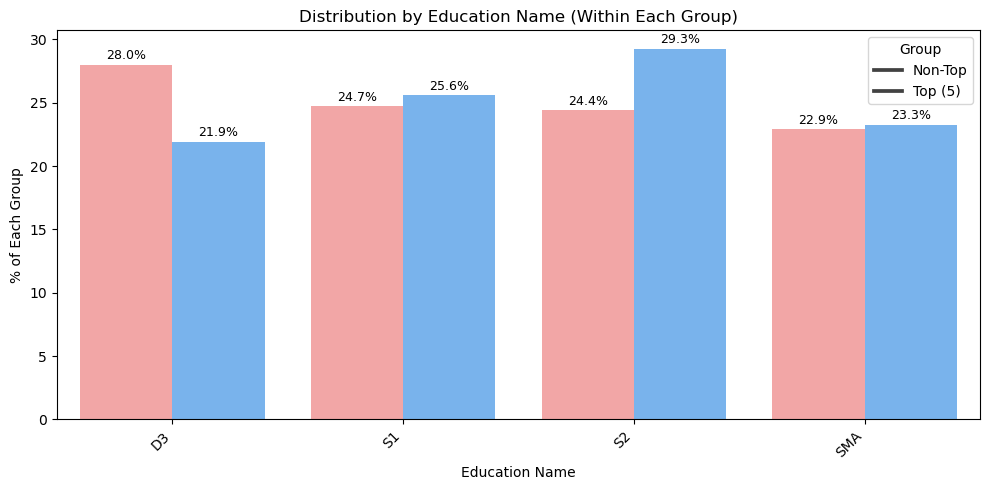


📊 Top vs Non-Top — Education Name


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
education_name,,,
S2,24.4,29.3,4.9
S1,24.7,25.6,0.9
SMA,22.9,23.3,0.4
D3,28.0,21.9,-6.1


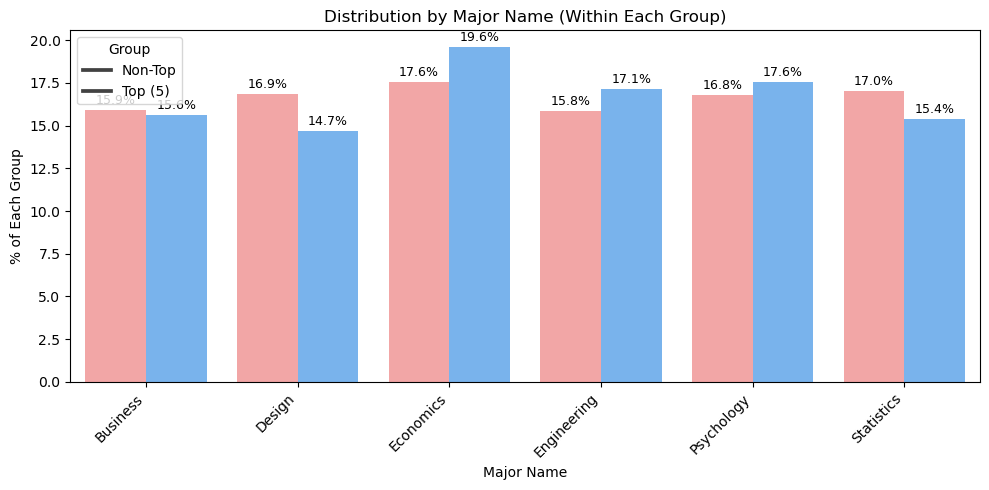


📊 Top vs Non-Top — Major Name


has_rating_5_label,Non-Top,Top (5),Δ (Top - Non-Top)
major_name,,,
Economics,17.6,19.6,2.0
Psychology,16.8,17.6,0.8
Engineering,15.8,17.1,1.3
Business,15.9,15.6,-0.3
Statistics,17.0,15.4,-1.6
Design,16.9,14.7,-2.2


In [32]:

# Make the hue label readable
base_with_perf["has_rating_5_label"] = base_with_perf["has_rating_5"].map({True: "Top (5)", False: "Non-Top"})

dim_columns = [
    "company_name", "area_name", "position_name", "department_name",
    "division_name", "directorate_name", "grade_name",
    "education_name", "major_name"
]

for col in dim_columns:
    if col not in base_with_perf.columns:
        print(f"⚠️ Skipping '{col}' (not found)")
        continue

    temp = base_with_perf[[col, "has_rating_5_label"]].fillna("Unknown")

    # Count per group and category
    counts = temp.groupby(["has_rating_5_label", col]).size().reset_index(name="count")

    # Normalize WITHIN each group (each group sums to 100%)
    counts["percent_within_group"] = counts.groupby("has_rating_5_label")["count"].transform(lambda x: 100 * x / x.sum())

    # Pivot for summary table
    pivot = counts.pivot(index=col, columns="has_rating_5_label", values="percent_within_group").fillna(0)
    pivot["Δ (Top - Non-Top)"] = pivot["Top (5)"] - pivot["Non-Top"]
    pivot_sorted = pivot.sort_values(by="Top (5)", ascending=False)

    # ===== Visualization (no Δ shown) =====
    plot_df = counts.copy()
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        data=plot_df,
        x=col,
        y="percent_within_group",
        hue="has_rating_5_label",
        palette=["#ff9999", "#66b3ff"]
    )
    ax.bar_label(ax.containers[0], fmt="%.1f%%", label_type="edge", fontsize=9, padding=2)
    ax.bar_label(ax.containers[1], fmt="%.1f%%", label_type="edge", fontsize=9, padding=2)
    plt.title(f"Distribution by {col.replace('_',' ').title()} (Within Each Group)")
    plt.ylabel("% of Each Group")
    plt.xlabel(col.replace("_"," ").title())
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Group", labels=["Non-Top", "Top (5)"])
    plt.tight_layout()
    plt.show()

    # ===== Tabular summary =====
    print(f"\n📊 Top vs Non-Top — {col.replace('_',' ').title()}")
    display(
        pivot_sorted[["Non-Top", "Top (5)", "Δ (Top - Non-Top)"]]
        .round(1)
        .head(10)  # show top 10 categories
    )

Insights:
- Grade III has higher percentage of top performers, while Grade V has lower
- S2 Education far higher percentage in top performers, while D3 lower
- Economics, Engineering, and Psychology has higher percentage in top performers

### 3.8 Years of Service

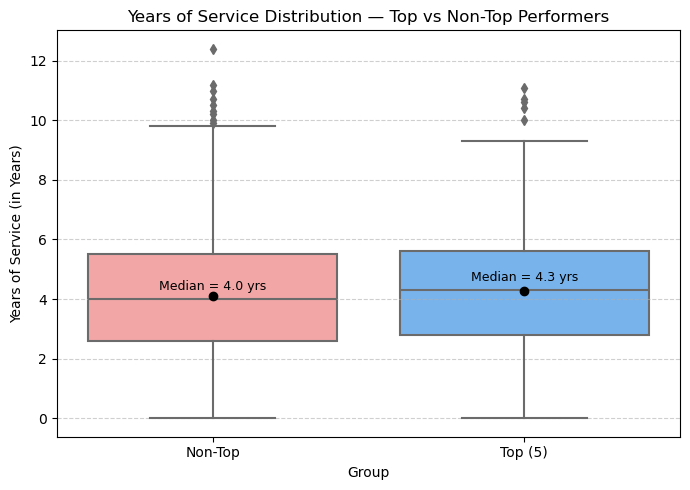

📊 Summary Statistics — Years of Service (in Years)


,count,mean,median,std,min,max
has_rating_5_label,,,,,,
Non-Top,1275,4.11,4.0,2.11,0.0,12.4
Top (5),735,4.28,4.3,2.08,0.0,11.1


In [33]:
# --- Convert months to years if not already done ---
if "years_of_service_years" not in base_with_perf.columns:
    base_with_perf["years_of_service_years"] = (base_with_perf["years_of_service_months"] / 12).round(1)

# --- Ensure label column exists ---
base_with_perf["has_rating_5_label"] = base_with_perf["has_rating_5"].map({
    True: "Top (5)",
    False: "Non-Top"
})

# --- Drop missing values for clean plotting ---
temp = base_with_perf.dropna(subset=["years_of_service_years"])

# --- Create boxplot ---
plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=temp,
    x="has_rating_5_label",
    y="years_of_service_years",
    palette=["#ff9999", "#66b3ff"],
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"}
)

# --- Customize labels and title ---
plt.title("Years of Service Distribution — Top vs Non-Top Performers")
plt.xlabel("Group")
plt.ylabel("Years of Service (in Years)")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# --- Add numeric medians on the plot ---
medians = temp.groupby("has_rating_5_label")["years_of_service_years"].median()
for i, median in enumerate(medians):
    ax.text(i, median + 0.3, f"Median = {median:.1f} yrs", ha='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# --- Print tabular summary ---
summary = temp.groupby("has_rating_5_label")["years_of_service_years"].agg(["count", "mean", "median", "std", "min", "max"]).round(2)
print("📊 Summary Statistics — Years of Service (in Years)")
display(summary)


Insight:
- Number of years worked in company has little effect on top performace
- Top performers only slightly higher in average and median years

### 3.9. Competency Ccores and Rating Correlation


📊 FULL CORRELATION MATRIX (pillars + rating)



,Commercial Savvy & Impact,Curiosity & Experimentation,Forward Thinking & Clarity,Growth Drive & Resilience,Insight & Decision Sharpness,"Lead, Inspire & Empower",Quality Delivery Discipline,Social Empathy & Awareness,Synergy & Team Orientation,Value Creation for Users,rating
Commercial Savvy & Impact,1.000,0.047,0.045,0.080,0.047,0.025,0.036,0.050,0.085,0.108,0.087
Curiosity & Experimentation,0.047,1.000,0.051,0.062,0.055,0.039,0.044,0.068,0.049,0.065,0.092
Forward Thinking & Clarity,0.045,0.051,1.000,0.047,0.046,0.040,0.042,0.069,0.057,0.056,0.078
Growth Drive & Resilience,0.080,0.062,0.047,1.000,0.050,0.032,0.042,0.047,0.133,0.049,0.082
Insight & Decision Sharpness,0.047,0.055,0.046,0.050,1.000,0.038,0.042,0.045,0.038,0.047,0.111
"Lead, Inspire & Empower",0.025,0.039,0.040,0.032,0.038,1.000,0.024,0.027,0.072,0.037,0.069
Quality Delivery Discipline,0.036,0.044,0.042,0.042,0.042,0.024,1.000,0.053,0.035,0.041,0.072
Social Empathy & Awareness,0.050,0.068,0.069,0.047,0.045,0.027,0.053,1.000,0.046,0.059,0.089
Synergy & Team Orientation,0.085,0.049,0.057,0.133,0.038,0.072,0.035,0.046,1.000,0.043,0.104
Value Creation for Users,0.108,0.065,0.056,0.049,0.047,0.037,0.041,0.059,0.043,1.000,0.103


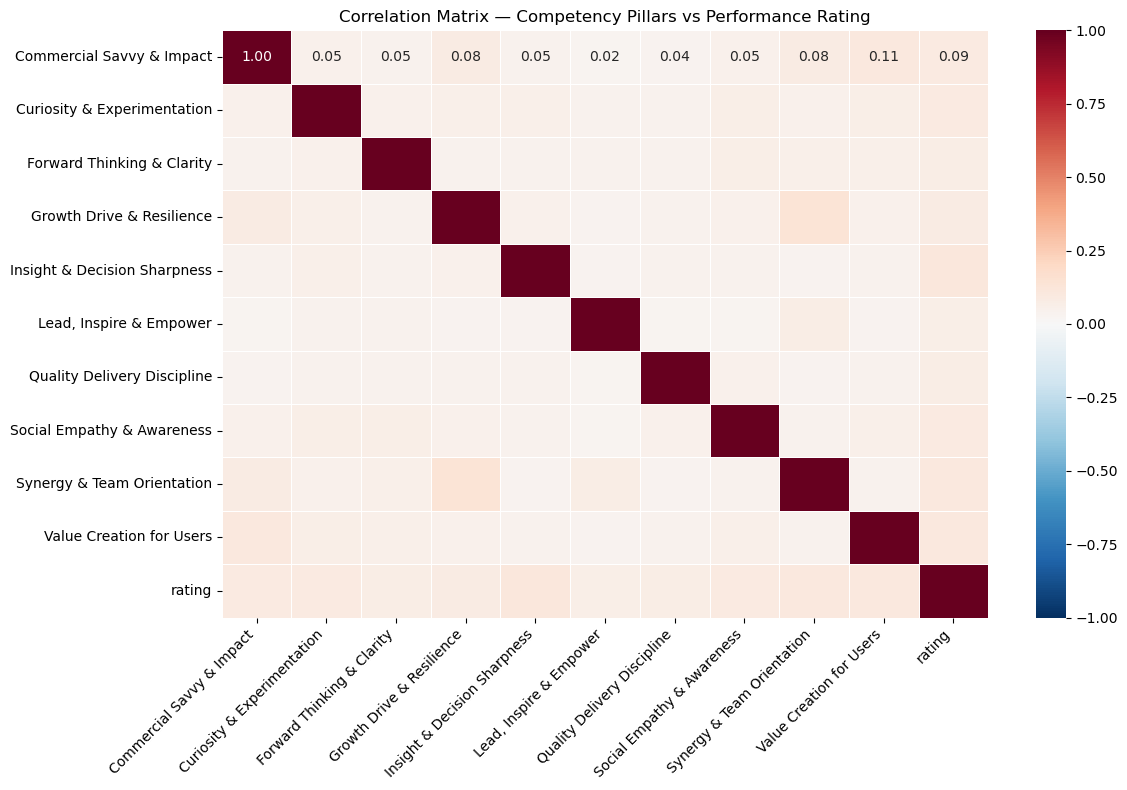


📊 CORRELATION OF EACH FULL PILLAR NAME WITH PERFORMANCE



,Correlation
Insight & Decision Sharpness,0.111
Synergy & Team Orientation,0.104
Value Creation for Users,0.103
Curiosity & Experimentation,0.092
Social Empathy & Awareness,0.089
Commercial Savvy & Impact,0.087
Growth Drive & Resilience,0.082
Forward Thinking & Clarity,0.078
Quality Delivery Discipline,0.072
"Lead, Inspire & Empower",0.069


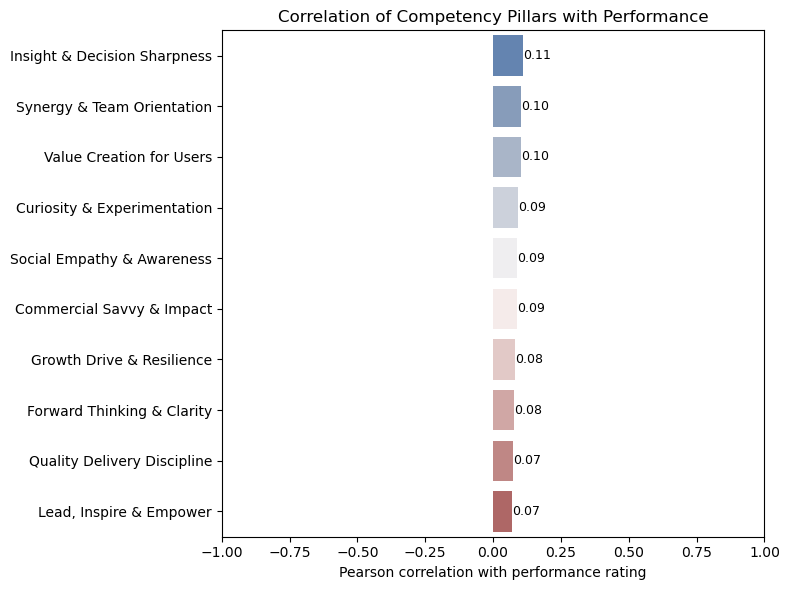

In [ ]:
# ---------- 1) Ensure numeric ----------
competencies_yearly["score"] = pd.to_numeric(competencies_yearly["score"], errors="coerce")
competencies_yearly["year"] = pd.to_numeric(competencies_yearly["year"], errors="coerce")
performance_yearly["rating"] = pd.to_numeric(performance_yearly["rating"], errors="coerce")

# ---------- 2) Merge competency pillars lookup table ----------
comp = competencies_yearly.merge(
    dim_competency_pillars,
    on="pillar_code",
    how="left"
)

# ---------- 3) Aggregate competency scores ----------
comp_agg = (
    comp.groupby(["employee_id", "pillar_label"], as_index=False)["score"]
        .mean()
)

# ---------- 4) Pivot: rows = employee, columns = full pillar label ----------
comp_wide = comp_agg.pivot_table(
    index="employee_id",
    columns="pillar_label",
    values="score",
    aggfunc="mean"
)

# ---------- 5) Merge performance (latest available) ----------
perf_latest = (
    performance_yearly
    .sort_values(["employee_id", "year"])
    .groupby("employee_id")
    .last()["rating"]
)

comp_perf = comp_wide.merge(
    perf_latest.rename("rating"),
    left_index=True,
    right_index=True,
    how="left"
)

# ---------- 6) Drop pillars with >50% missing ----------
drop_cols = [
    c for c in comp_perf.columns
    if c != "rating" and comp_perf[c].isna().mean() > 0.5
]

if drop_cols:
    print("Dropping pillars with >50% missing:", drop_cols)
    comp_perf = comp_perf.drop(columns=drop_cols)

# ---------- 7) Fill NaN for correlation only ----------
comp_for_corr = comp_perf.fillna(comp_perf.mean())

# ---------- 8) Compute correlation ----------
corr = comp_for_corr.corr(method="pearson")

# ---------- 9) Table: Show full correlation matrix ----------
print("\n📊 FULL CORRELATION MATRIX (pillars + rating)\n")
display(corr.round(3))

# ---------- 10) Heatmap ----------
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=.4,
    vmin=-1,
    vmax=1
)
plt.title("Correlation Matrix — Competency Pillars vs Performance Rating")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------- 11) Extract pillar→rating correlations ----------
if "rating" in corr.columns:
    corr_with_rating = (
        corr["rating"]
        .drop("rating")
        .sort_values(ascending=False)
    )

    # ---- Table ----
    print("\n📊 CORRELATION OF EACH FULL PILLAR NAME WITH PERFORMANCE\n")
    display(corr_with_rating.to_frame("Correlation").round(3))

    # ---- Bar Chart ----
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=corr_with_rating.values,
        y=corr_with_rating.index,
        palette="vlag"
    )
    plt.xlabel("Pearson correlation with performance rating")
    plt.title("Correlation of Competency Pillars with Performance")

    # Add text labels
    for i, v in enumerate(corr_with_rating.values):
        plt.text(
            v,
            i,
            f"{v:.2f}",
            va="center",
            ha='left' if v >= 0 else 'right',
            fontsize=9
        )

    plt.xlim(-1, 1)
    plt.tight_layout()
    plt.show()
else:
    print("Rating column missing — cannot compute pillar correlations.")


## 4. Final Conclusion

### Performance Potential Score (PPS) — Final Design Rationale

The Performance Potential Score (PPS) is designed to predict the likelihood that an employee belongs to the top-performing group (rating = 5). The PPS combines multiple data sources—competencies, psychometrics, personality, and aptitude—into a single interpretable metric grounded in data, statistical correlations, and behavioral science.

This document explains what the PPS includes and, more importantly, why each component matters.

#### Guiding Principles for PPS Design
1. Fairness
No factors that create structural bias (e.g., education level, university major) are included.
Only attributes reflecting skill, behavior, or potential are used.

2. Predictive Value
We include only variables that show measurable, repeatable relationships with performance:
Correlation (continuous predictor strength)
Top vs Non-top delta (group group difference)

3. Interpretability
HR, managers, and employees must understand how the score is produced.
The formula uses weighted averages rather than opaque ML models.

4. Actionability
Every component should point to real development levers (upskilling, coaching, role fit).

#### Components Included in PPS
PPS is composed of four parts, each contributing differently based on predictive strength.

1. Competency Pillars (55%) — Strongest Predictor
Competency scores (scale 1–5) are the most consistent predictor of performance.
Using correlation with performance rating, we derive the following weights:
Pillar	Corr	Weight (normalized)
Insight & Decision Sharpness	0.111	1.00
Synergy & Team Orientation	0.104	0.94
Value Creation for Users	0.103	0.93
Curiosity & Experimentation	0.092	0.83
Social Empathy & Awareness	0.089	0.80
Commercial Savvy & Impact	0.087	0.78
Growth Drive & Resilience	0.082	0.74
Forward Thinking & Clarity	0.078	0.70
Quality Delivery Discipline	0.072	0.65
Lead, Inspire & Empower	0.069	0.62

Rationale:
Correlation analysis shows that cognitive, interpersonal, and decision-making pillars have the highest predictive power for performance. Leadership and delivery-oriented pillars, while important, show weaker statistical links to top performance.

2. PAPI Scales (25%) — Distinguish High Performers
PAPI traits (scale 1–10) help identify behavioral drivers and derailers of strong performance.
We weight each PAPI scale using the Top 5 vs Non-Top delta because:
Personality traits have nonlinear effects
Group differences capture behavioral patterns more cleanly than correlations
Positive drivers (high delta → add weight)
Negative drivers (negative delta → subtractive weight)
This allows the behavioral component to complement competencies.

3. Aptitude Scores (15%) — Cognitive Potential

We combine:
Pauli (20–100)
GTQ (1–50)
Cognitive Index / IQ (80–140)

Rationale:
Aptitude measures show moderate predictive value and are more stable over time than personality. 
However: Pauli & GTQ correlate positively

IQ shows neutral to slightly negative correlation after controlling for other variables
→ high IQ without execution competency does not guarantee top performance
Therefore we apply:
positive weighting for Pauli & GTQ
very mild or neutral weighting for IQ

4. Behavioral Type (5%) — Weak but Useful

DISC styles and MBTI types are not scientifically deterministic, but we keep them as a small component because:
Certain traits (e.g., ENFP, INTJ, ISTP) appear overrepresented in the top group
DISC C-types or DC-types show scoring advantages

Rationale:
These effects are real but small → 5% weighting ensures they inform but do not dominate the score.

#### What PPS Does Not Include (Fairness Rationale)
1. Education Level (SMA, D3, S1, S2)
Although deltas show slight differences (S2 has +4.9%), these are not causal:
Higher education often correlates with job family, not performance
Including this would penalize capable employees without access to higher degrees

Therefore: education is excluded.

2. Major (Psychology, Statistics, Engineering, etc.)
Deltas are small (range: −2.2% to +2.0%) and mostly reflect:
hiring patterns
job clusters
historical preferences

Majors do not reflect current or future performance capability.
Therefore: major is excluded.

#### Final PPS Formula
PPS = (0.55 × Competency Score)
    + (0.25 × PAPI Score)
    + (0.15 × Aptitude Score)
    + (0.05 × Behavioral Score)

All components are normalized to a 0–100 scale before weighting.

## 5. Next Improvements

Focus on correlation and machine learning metrics to dig deeper